# Gentrification Degree Index (GDI) for Paris, 2013–2021

This notebook implements a transparent, replicable Gentrification Degree Index following the theoretical framework developed for the thesis. The GDI integrates economic, social, and demographic dimensions to quantify neighborhood-level gentrification across 71 Parisian residential neighborhoods.

## Theoretical Foundation

The index operationalizes gentrification through three balanced dimensions:
- **Economic**: Median income per consumption unit, median sale price per m²
- **Social**: Shares of cadres and ouvriers, higher-education attainment
- **Demographic**: Age-balance (young adults vs. seniors), immigrant share

The methodology employs pooled standardization for temporal comparability, dimension-balanced aggregation, and longitudinal change metrics that distinguish level, velocity, and acceleration.

## 1. Setup and Imports

In [ ]:
!pip install pandas numpy geopandas matplotlib seaborn libpysal esda splot scikit-learn scipy

In [5]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Spatial analysis
from libpysal.weights import Queen
from esda.moran import Moran, Moran_Local
from splot.esda import moran_scatterplot, lisa_cluster

# Dimensionality reduction for sensitivity
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import spearmanr, kendalltau

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)
plt.style.use('seaborn-v0_8-darkgrid')

# Paths
DATA_DIR = Path('../datasets')
OUTPUT_DIR = Path('../output')
OUTPUT_DIR.mkdir(exist_ok=True)

print("Environment ready.")

Environment ready.


## 2. Data Loading and Harmonization

In [9]:
# Load the three cross-sections
files = [
    'paris_merged_2013.parquet',
    'paris_merged_2017.parquet',
    'paris_merged_2021.parquet'
]

dfs = []
for file in files:
    df_temp = pd.read_parquet(DATA_DIR / file)
    year = int(file.split('_')[-1].replace('.parquet', ''))
    df_temp['annee'] = year
    dfs.append(df_temp)
    print(f"Loaded {file}: {len(df_temp)} neighborhoods")

# Concatenate into long panel
df = pd.concat(dfs, ignore_index=True)

print(f"\nPanel structure: {len(df)} rows, {df['annee'].nunique()} years, {df['neighborhood'].nunique()} unique neighborhoods")
print(f"Years: {sorted(df['annee'].unique())}")

# Validation: ensure 71 neighborhoods per year
counts = df.groupby('annee')['neighborhood'].nunique()
print("\nNeighborhoods per year:")
print(counts)
assert all(counts == 71), "Mismatch in number of neighborhoods per year"

df.head()

Loaded paris_merged_2013.parquet: 71 neighborhoods
Loaded paris_merged_2017.parquet: 71 neighborhoods
Loaded paris_merged_2021.parquet: 71 neighborhoods

Panel structure: 213 rows, 3 years, 71 unique neighborhoods
Years: [np.int64(2013), np.int64(2017), np.int64(2021)]

Neighborhoods per year:
annee
2013    71
2017    71
2021    71
Name: neighborhood, dtype: int64


,neighborhood,annee,type_neighborhood,pct_H,n_iris_H,n_iris_D,n_iris_A,n_iris_total,median_uc,pop_bac_sup,pop_total,pop_cadres,pop_ouvriers,pop_25_39,pop_65plus,pop_immigres,pop_15plus,pct_cadres,pct_ouvriers,pct_25_39,pct_65plus,pct_immigres,prix_m2_mean,prix_m2_median,n_transactions
0,Amérique,2013,Habitation,96.000,24.0,0.0,1.0,25.0,20614.109,16904.385,57481.803,9091.497,3357.822,13509.411,7724.403,13804.500,47253.389,19.240,7.106,23.502,13.438,24.015,6569.463,6471.995,388.0
1,Arsenal,2013,Habitation,100.000,4.0,0.0,0.0,4.0,33392.714,4084.698,8474.816,2334.436,182.888,2214.403,1461.937,1350.124,7342.795,31.792,2.491,26.129,17.250,15.931,10580.684,10460.949,120.0
2,Arts et Métiers,2013,Habitation,100.000,5.0,0.0,0.0,5.0,27563.000,4755.998,9800.730,3237.208,371.208,3464.511,1030.823,2324.693,8732.693,37.070,4.251,35.350,10.518,23.720,9072.377,9000.000,175.0
3,Auteuil,2013,Habitation,96.774,30.0,0.0,1.0,31.0,37822.398,33696.653,72956.752,17005.252,1549.555,12839.725,16538.844,13743.670,62502.181,27.207,2.479,17.599,22.669,18.838,8191.514,8200.000,894.0
4,Batignolles,2013,Habitation,100.000,16.0,0.0,0.0,16.0,33004.000,19620.769,42771.955,13033.995,1362.242,13637.257,5007.149,7136.568,36274.939,35.931,3.755,31.884,11.707,16.685,8382.644,8366.601,754.0


In [10]:
# Inspect available columns
print("Available columns:")
print(df.columns.tolist())

Available columns:
['neighborhood', 'annee', 'type_neighborhood', 'pct_H', 'n_iris_H', 'n_iris_D', 'n_iris_A', 'n_iris_total', 'median_uc', 'pop_bac_sup', 'pop_total', 'pop_cadres', 'pop_ouvriers', 'pop_25_39', 'pop_65plus', 'pop_immigres', 'pop_15plus', 'pct_cadres', 'pct_ouvriers', 'pct_25_39', 'pct_65plus', 'pct_immigres', 'prix_m2_mean', 'prix_m2_median', 'n_transactions']


## 3. Indicator Construction

We construct seven indicators aligned with the theoretical framework:

### Economic Dimension
1. **median_uc**: Median income per consumption unit (positive polarity)
2. **prix_m2_median**: Median sale price per m² (positive polarity)

### Social Dimension
3. **pct_cadres**: Share of cadres among adults 15+ (positive polarity)
4. **pct_ouvriers**: Share of ouvriers among adults 15+ (negative polarity)
5. **pct_bac_sup**: Share with Bac+2 or higher among adults 15+ (positive polarity)

### Demographic Dimension
6. **age_balance**: Percentage 25–39 minus percentage 65+ (positive polarity)
7. **pct_immigres**: Immigrant share (negative polarity)

In [11]:
# Derive education percentage
df['pct_bac_sup'] = 100 * df['pop_bac_sup'] / df['pop_15plus']

# Derive age balance
df['age_balance'] = df['pct_25_39'] - df['pct_65plus']

# Note: Using prix_m2_median as-is (nominal prices)
# No deflation applied per user request

print("Derived indicators created.")
print(f"\npct_bac_sup range: {df['pct_bac_sup'].min():.1f}% to {df['pct_bac_sup'].max():.1f}%")
print(f"age_balance range: {df['age_balance'].min():.1f} to {df['age_balance'].max():.1f}")

Derived indicators created.

pct_bac_sup range: 30.0% to 69.1%
age_balance range: -9.3 to 28.8


In [13]:
# Define the seven indicators with their polarity signs
indicators = [
    ('median_uc', +1, 'Economic'),
    ('prix_m2_median', +1, 'Economic'),
    ('pct_cadres', +1, 'Social'),
    ('pct_ouvriers', -1, 'Social'),
    ('pct_bac_sup', +1, 'Social'),
    ('age_balance', +1, 'Demographic'),
    ('pct_immigres', -1, 'Demographic')
]

indicator_df = pd.DataFrame(indicators, columns=['Variable', 'Polarity', 'Dimension'])
indicator_df['Sign'] = indicator_df['Polarity'].map({1: '+', -1: '−'})

print("\nIndicator structure:")
print(indicator_df[['Dimension', 'Variable', 'Sign']].to_string(index=False))


Indicator structure:
  Dimension       Variable Sign
   Economic      median_uc    +
   Economic prix_m2_median    +
     Social     pct_cadres    +
     Social   pct_ouvriers    −
     Social    pct_bac_sup    +
Demographic    age_balance    +
Demographic   pct_immigres    −


## 4. Pooled Winsorization and Standardization

To ensure temporal comparability, we apply pooled standardization:
1. **Winsorize** each indicator at the 2.5th and 97.5th percentiles across all neighborhoods and years
2. **Standardize** to z-scores using pooled mean and standard deviation
3. **Apply polarity** so that higher values indicate stronger gentrification signal

In [14]:
# Pooled winsorization and standardization
for var, sign, dim in indicators:
    # Winsorize at pooled percentiles
    lower = df[var].quantile(0.025)
    upper = df[var].quantile(0.975)
    series_winsorized = df[var].clip(lower=lower, upper=upper)
    
    # Apply polarity sign and standardize
    signed_series = sign * series_winsorized
    mu = signed_series.mean()
    sigma = signed_series.std()
    
    # Store z-score
    df[f'z_{var}'] = (signed_series - mu) / sigma
    
    print(f"{var:20s} | Pooled μ={mu:10.2f}, σ={sigma:8.2f} | Winsorized [{lower:.2f}, {upper:.2f}]")

print("\nPooled z-scores computed for all indicators.")

median_uc            | Pooled μ=  31943.33, σ= 7202.43 | Winsorized [18035.02, 46357.00]
prix_m2_median       | Pooled μ=   9927.93, σ= 1985.25 | Winsorized [6530.40, 14442.58]
pct_cadres           | Pooled μ=     30.87, σ=    5.29 | Winsorized [19.01, 40.10]
pct_ouvriers         | Pooled μ=     -3.86, σ=    1.76 | Winsorized [1.75, 8.53]
pct_bac_sup          | Pooled μ=     53.71, σ=    7.42 | Winsorized [36.08, 64.47]
age_balance          | Pooled μ=      9.36, σ=    8.24 | Winsorized [-6.51, 23.36]
pct_immigres         | Pooled μ=    -19.90, σ=    3.73 | Winsorized [15.21, 29.87]

Pooled z-scores computed for all indicators.


In [15]:
# Verify standardization
z_cols = [f'z_{var}' for var, _, _ in indicators]
print("\nStandardization check (should be ~0 mean, ~1 std):")
print(df[z_cols].describe().loc[['mean', 'std']].T)


Standardization check (should be ~0 mean, ~1 std):
                       mean  std
z_median_uc       6.005e-16  1.0
z_prix_m2_median -1.334e-16  1.0
z_pct_cadres     -5.671e-16  1.0
z_pct_ouvriers    6.672e-17  1.0
z_pct_bac_sup     1.468e-15  1.0
z_age_balance     2.002e-16  1.0
z_pct_immigres   -7.798e-16  1.0


## 5. Subindices and Composite GDI

We aggregate standardized indicators into three dimension-balanced subindices, then average to create the overall GDI:

$$E_{it} = \frac{1}{2}\left(z^{\text{median\_uc}}_{it} + z^{\text{prix\_m2}}_{it}\right)$$

$$S_{it} = \frac{1}{3}\left(z^{\text{cadres}}_{it} + z^{\text{bac\_sup}}_{it} + z^{\text{ouvriers}}_{it}^{(-)}\right)$$

$$D_{it} = \frac{1}{2}\left(z^{\text{age\_balance}}_{it} + z^{\text{immigres}}_{it}^{(-)}\right)$$

$$GDI'_{it} = \frac{E_{it} + S_{it} + D_{it}}{3}$$

Final GDI is min-max rescaled to [0, 100].

In [16]:
# Economic subindex: average of income and price
df['E'] = (df['z_median_uc'] + df['z_prix_m2_median']) / 2

# Social subindex: average of cadres, education, ouvriers
df['S'] = (df['z_pct_cadres'] + df['z_pct_bac_sup'] + df['z_pct_ouvriers']) / 3

# Demographic subindex: average of age balance and immigrant share
df['D'] = (df['z_age_balance'] + df['z_pct_immigres']) / 2

# Raw composite: equal weight across dimensions
df['GDI_raw'] = (df['E'] + df['S'] + df['D']) / 3

print("Subindices created.")
print(f"\nGDI_raw range: {df['GDI_raw'].min():.3f} to {df['GDI_raw'].max():.3f}")
print(f"Mean: {df['GDI_raw'].mean():.3f}, Std: {df['GDI_raw'].std():.3f}")

Subindices created.

GDI_raw range: -1.790 to 1.086
Mean: 0.000, Std: 0.652


In [17]:
# Min-max rescale to [0, 100] across all neighborhoods and years
gdi_min = df['GDI_raw'].min()
gdi_max = df['GDI_raw'].max()

df['GDI'] = 100 * (df['GDI_raw'] - gdi_min) / (gdi_max - gdi_min)

print(f"GDI rescaled to [0, 100].")
print(f"Min: {df['GDI'].min():.1f}, Max: {df['GDI'].max():.1f}")
print(f"Mean: {df['GDI'].mean():.1f}, Median: {df['GDI'].median():.1f}")

GDI rescaled to [0, 100].
Min: 0.0, Max: 100.0
Mean: 62.2, Median: 68.2


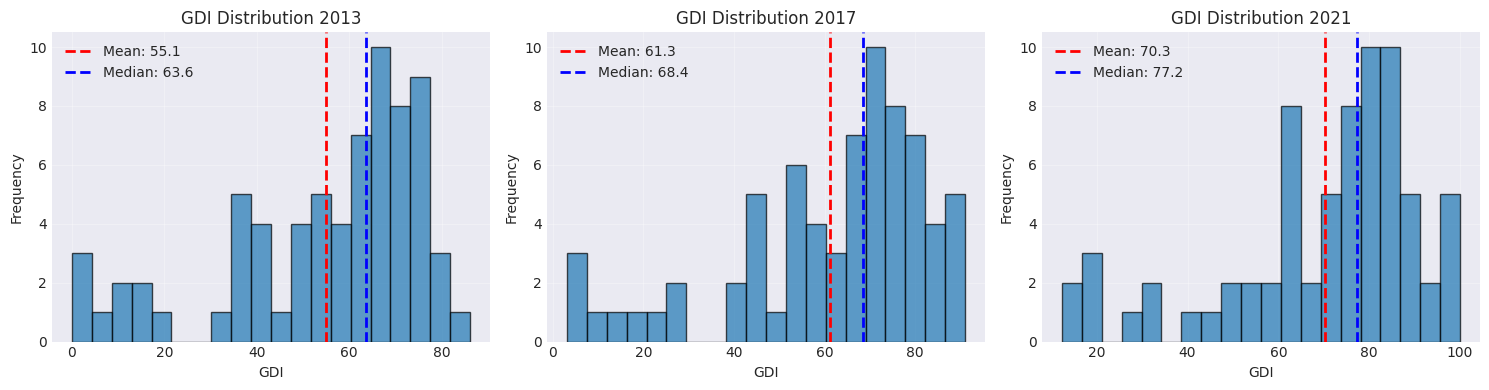


GDI summary statistics by year:
       count    mean     std     min     25%     50%     75%      max
annee                                                                
2013    71.0  55.067  21.692   0.000  42.435  63.624  70.748   86.139
2017    71.0  61.293  22.248   3.161  53.115  68.409  76.818   91.007
2021    71.0  70.334  21.764  12.353  62.740  77.209  85.071  100.000


In [18]:
# Distribution of GDI by year
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, year in enumerate([2013, 2017, 2021]):
    data = df[df['annee'] == year]['GDI']
    axes[i].hist(data, bins=20, edgecolor='black', alpha=0.7)
    axes[i].axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.1f}')
    axes[i].axvline(data.median(), color='blue', linestyle='--', linewidth=2, label=f'Median: {data.median():.1f}')
    axes[i].set_title(f'GDI Distribution {year}')
    axes[i].set_xlabel('GDI')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'gdi_distributions_by_year.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGDI summary statistics by year:")
print(df.groupby('annee')['GDI'].describe())

## 6. Temporal Evolution Analysis

We compute:
- **Period changes**: Δ₁₃₋₁₇, Δ₁₇₋₂₁, Δ₁₃₋₂₁
- **Velocity**: Change per year (Δ / 4 years)
- **Acceleration**: Change in velocity between periods

In [20]:
# Pivot to wide format for change calculations
wide = df.pivot_table(
    index='neighborhood',
    columns='annee',
    values=['GDI', 'E', 'S', 'D']
)

# Flatten column names
wide.columns = [f'{var}_{year}' for var, year in wide.columns]
wide = wide.reset_index()

print(f"Wide format: {wide.shape}")
wide.head()

Wide format: (71, 13)


,neighborhood,D_2013,D_2017,D_2021,E_2013,E_2017,E_2021,GDI_2013,GDI_2017,GDI_2021,S_2013,S_2017,S_2021
0,Amérique,-0.508,-0.672,-0.741,-1.642,-1.443,-0.734,12.505,15.554,25.733,-2.139,-1.912,-1.673
1,Arsenal,0.502,0.202,0.213,0.235,0.380,1.144,75.455,77.005,82.682,0.404,0.692,0.407
2,Arts et Métiers,0.339,0.316,0.530,-0.538,-0.053,0.641,63.992,71.346,88.771,0.351,0.524,1.118
3,Auteuil,-0.734,-0.923,-1.009,-0.027,0.066,0.804,53.873,53.692,63.384,0.040,0.120,0.304
4,Batignolles,1.087,1.194,1.188,-0.320,0.125,0.869,75.257,86.491,95.249,0.356,0.773,0.791


In [21]:
# Period changes
wide['delta_13_17'] = wide['GDI_2017'] - wide['GDI_2013']
wide['delta_17_21'] = wide['GDI_2021'] - wide['GDI_2017']
wide['delta_13_21'] = wide['GDI_2021'] - wide['GDI_2013']

# Velocity (change per year)
wide['vel_13_17'] = wide['delta_13_17'] / 4
wide['vel_17_21'] = wide['delta_17_21'] / 4
wide['vel_13_21'] = wide['delta_13_21'] / 8

# Acceleration (change in velocity)
wide['accel'] = wide['vel_17_21'] - wide['vel_13_17']

print("\nChange metrics computed.")
print(f"\nOverall change (2013→2021):")
print(f"  Mean Δ: {wide['delta_13_21'].mean():.2f}")
print(f"  Median Δ: {wide['delta_13_21'].median():.2f}")
print(f"  Std Δ: {wide['delta_13_21'].std():.2f}")
print(f"\nAcceleration:")
print(f"  Mean: {wide['accel'].mean():.3f}")
print(f"  Positive accel: {(wide['accel'] > 0).sum()} neighborhoods")
print(f"  Negative accel: {(wide['accel'] < 0).sum()} neighborhoods")


Change metrics computed.

Overall change (2013→2021):
  Mean Δ: 15.27
  Median Δ: 14.05
  Std Δ: 7.03

Acceleration:
  Mean: 0.704
  Positive accel: 48 neighborhoods
  Negative accel: 23 neighborhoods


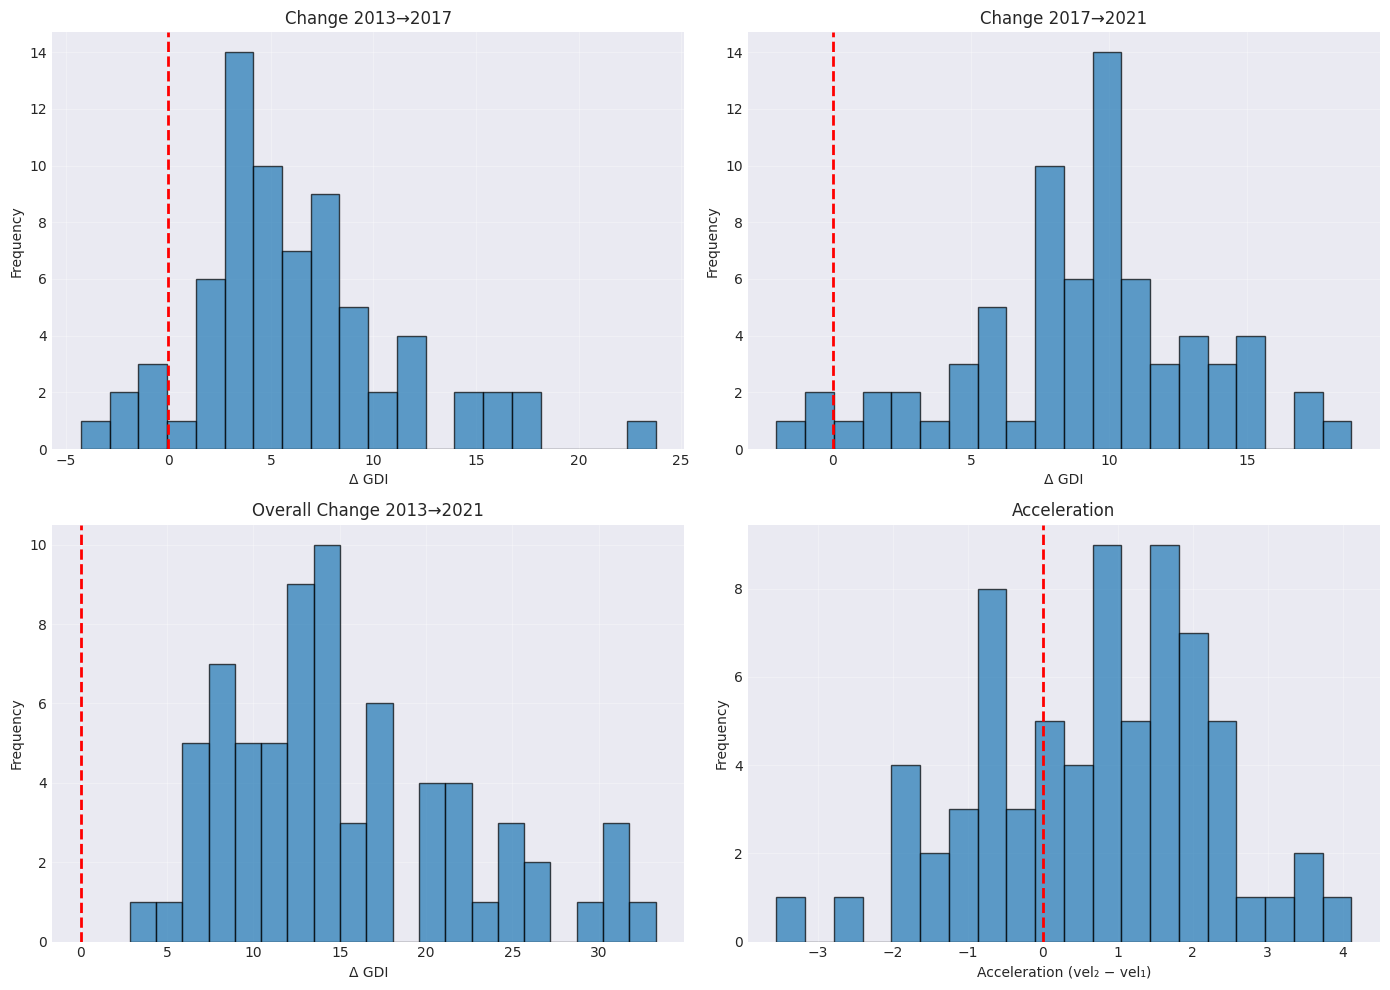

In [22]:
# Visualize change distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Period 1 change
axes[0, 0].hist(wide['delta_13_17'], bins=20, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title('Change 2013→2017')
axes[0, 0].set_xlabel('Δ GDI')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# Period 2 change
axes[0, 1].hist(wide['delta_17_21'], bins=20, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_title('Change 2017→2021')
axes[0, 1].set_xlabel('Δ GDI')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Overall change
axes[1, 0].hist(wide['delta_13_21'], bins=20, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_title('Overall Change 2013→2021')
axes[1, 0].set_xlabel('Δ GDI')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

# Acceleration
axes[1, 1].hist(wide['accel'], bins=20, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_title('Acceleration')
axes[1, 1].set_xlabel('Acceleration (vel₂ − vel₁)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'gdi_change_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Neighborhood Classification

Classify neighborhoods into trajectory types using quantile and standard-deviation thresholds:

- **Accelerating**: High overall change (>75th percentile) + positive acceleration + above-median 2021 level
- **Moderate/Stable**: Middle range of change (25th–75th percentile) or positive change in both periods with near-zero acceleration
- **Declining/Non-gentrifying**: Low or negative change (≤25th percentile) or negative change in second period

In [23]:
# Compute quantile thresholds
q25 = wide['delta_13_21'].quantile(0.25)
q75 = wide['delta_13_21'].quantile(0.75)
median_gdi_2021 = wide['GDI_2021'].median()

print(f"Classification thresholds:")
print(f"  25th percentile Δ₁₃₋₂₁: {q25:.2f}")
print(f"  75th percentile Δ₁₃₋₂₁: {q75:.2f}")
print(f"  Median GDI₂₀₂₁: {median_gdi_2021:.2f}")

# Classification logic
def classify_trajectory(row):
    delta = row['delta_13_21']
    accel = row['accel']
    gdi_2021 = row['GDI_2021']
    delta_17_21 = row['delta_17_21']
    
    # Accelerating: high change, positive acceleration, above-median level
    if delta > q75 and accel > 0 and gdi_2021 > median_gdi_2021:
        return 'Accelerating'
    
    # Declining: low change or negative second-period change
    elif delta <= q25 or delta_17_21 <= 0:
        return 'Declining/Non-gentrifying'
    
    # Moderate/Stable: everything else
    else:
        return 'Moderate/Stable'

wide['trajectory'] = wide.apply(classify_trajectory, axis=1)

print("\nTrajectory classification:")
print(wide['trajectory'].value_counts())
print(f"\nProportions:")
print(wide['trajectory'].value_counts(normalize=True).mul(100).round(1))

Classification thresholds:
  25th percentile Δ₁₃₋₂₁: 10.15
  75th percentile Δ₁₃₋₂₁: 19.69
  Median GDI₂₀₂₁: 77.21

Trajectory classification:
trajectory
Moderate/Stable              49
Declining/Non-gentrifying    18
Accelerating                  4
Name: count, dtype: int64

Proportions:
trajectory
Moderate/Stable              69.0
Declining/Non-gentrifying    25.4
Accelerating                  5.6
Name: proportion, dtype: float64


In [24]:
# Profile trajectories by mean characteristics
profile_cols = ['GDI_2013', 'GDI_2021', 'delta_13_21', 'vel_13_21', 'accel']
trajectory_profiles = wide.groupby('trajectory')[profile_cols].mean()

print("\nTrajectory profiles (mean values):")
print(trajectory_profiles.round(2))


Trajectory profiles (mean values):
                           GDI_2013  GDI_2021  delta_13_21  vel_13_21  accel
trajectory                                                                  
Accelerating                  70.40     93.76        23.36       2.92   1.64
Declining/Non-gentrifying     63.72     71.32         7.60       0.95   0.45
Moderate/Stable               50.64     68.06        17.42       2.18   0.72


## 8. Baseline-Adjusted Change

To account for ceiling effects, we regress overall change on baseline GDI and use residuals as a baseline-adjusted metric.

In [25]:
from scipy.stats import linregress

# Regress delta_13_21 on GDI_2013
slope, intercept, r_value, p_value, std_err = linregress(wide['GDI_2013'], wide['delta_13_21'])

print(f"Regression: Δ₁₃₋₂₁ ~ GDI₂₀₁₃")
print(f"  Slope: {slope:.4f}")
print(f"  Intercept: {intercept:.4f}")
print(f"  R²: {r_value**2:.4f}")
print(f"  p-value: {p_value:.4e}")

# Compute residuals
wide['delta_predicted'] = intercept + slope * wide['GDI_2013']
wide['delta_residual'] = wide['delta_13_21'] - wide['delta_predicted']

print(f"\nBaseline-adjusted change (residuals):")
print(f"  Mean: {wide['delta_residual'].mean():.2e} (should be ~0)")
print(f"  Std: {wide['delta_residual'].std():.2f}")

Regression: Δ₁₃₋₂₁ ~ GDI₂₀₁₃
  Slope: -0.0492
  Intercept: 17.9741
  R²: 0.0230
  p-value: 2.0637e-01

Baseline-adjusted change (residuals):
  Mean: 3.88e-15 (should be ~0)
  Std: 6.94


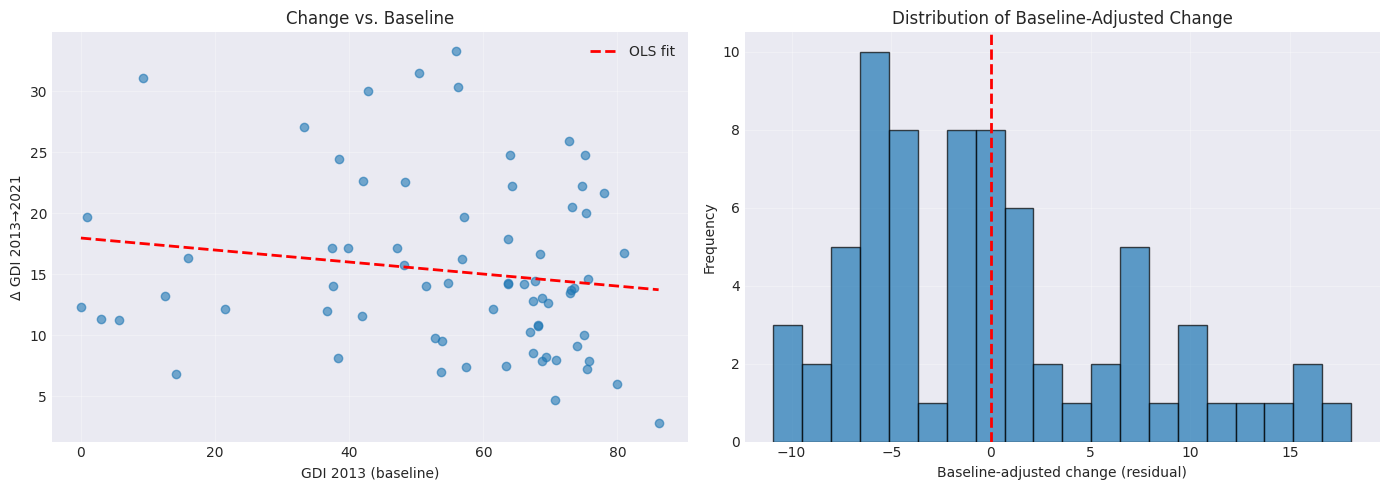

In [26]:
# Visualize baseline adjustment
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter: Change vs. baseline
axes[0].scatter(wide['GDI_2013'], wide['delta_13_21'], alpha=0.6)
x_range = np.linspace(wide['GDI_2013'].min(), wide['GDI_2013'].max(), 100)
axes[0].plot(x_range, intercept + slope * x_range, 'r--', linewidth=2, label='OLS fit')
axes[0].set_xlabel('GDI 2013 (baseline)')
axes[0].set_ylabel('Δ GDI 2013→2021')
axes[0].set_title('Change vs. Baseline')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals distribution
axes[1].hist(wide['delta_residual'], bins=20, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Baseline-adjusted change (residual)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Baseline-Adjusted Change')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'baseline_adjusted_change.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Spatial Analysis

We test for spatial autocorrelation using:
- **Global Moran's I**: Overall clustering of GDI values
- **Local LISA**: Identification of high-high, low-low clusters and spatial outliers

In [31]:
# Load spatial geometry
gdf = gpd.read_file(DATA_DIR / 'quartiers_paris.geojson')

print(f"Loaded {len(gdf)} neighborhood geometries.")
print(f"CRS: {gdf.crs}")
print(f"GeoJSON columns: {gdf.columns.tolist()}")

# Merge with wide data (GeoJSON has 'quartier', wide has 'neighborhood')
gdf_analysis = gdf.merge(wide, left_on='quartier', right_on='neighborhood', how='left')

print(f"\nMerged GeoDataFrame: {len(gdf_analysis)} rows")
print(f"Missing GDI values: {gdf_analysis['GDI_2021'].isna().sum()}")

gdf_analysis.head()

Loaded 94 neighborhood geometries.
CRS: EPSG:4326
GeoJSON columns: ['quartier', 'type_quartier', 'n_iris_H', 'n_iris_D', 'n_iris_A', 'n_iris_total', 'pct_H', 'geometry']

Merged GeoDataFrame: 94 rows
Missing GDI values: 23


,quartier,type_quartier,n_iris_H,n_iris_D,n_iris_A,n_iris_total,pct_H,geometry,neighborhood,D_2013,D_2017,D_2021,E_2013,E_2017,E_2021,GDI_2013,GDI_2017,GDI_2021,S_2013,S_2017,S_2021,delta_13_17,delta_17_21,delta_13_21,vel_13_17,vel_17_21,vel_13_21,accel,trajectory,delta_predicted,delta_residual
0,Amérique,Habitation,24,0,1,25,96.000,"POLYGON ((2.38745 48.87466, 2.38739 48.8758, 2...",Amérique,-0.508,-0.672,-0.741,-1.642,-1.443,-0.734,12.505,15.554,25.733,-2.139,-1.912,-1.673,3.049,10.179,13.228,0.762,2.545,1.653,1.783,Moderate/Stable,17.359,-4.131
1,Arsenal,Habitation,4,0,0,4,100.000,"POLYGON ((2.36479 48.84738, 2.36164 48.84951, ...",Arsenal,0.502,0.202,0.213,0.235,0.380,1.144,75.455,77.005,82.682,0.404,0.692,0.407,1.549,5.677,7.226,0.387,1.419,0.903,1.032,Declining/Non-gentrifying,14.265,-7.038
2,Arts et Métiers,Habitation,5,0,0,5,100.000,"POLYGON ((2.35825 48.86337, 2.35673 48.86383, ...",Arts et Métiers,0.339,0.316,0.530,-0.538,-0.053,0.641,63.992,71.346,88.771,0.351,0.524,1.118,7.354,17.425,24.779,1.838,4.356,3.097,2.518,Accelerating,14.828,9.950
3,Auteuil,Habitation,30,0,1,31,96.774,"POLYGON ((2.2663 48.83875, 2.26557 48.8381, 2....",Auteuil,-0.734,-0.923,-1.009,-0.027,0.066,0.804,53.873,53.692,63.384,0.040,0.120,0.304,-0.181,9.691,9.510,-0.045,2.423,1.189,2.468,Declining/Non-gentrifying,15.326,-5.815
4,Bassin de l'Arsenal,Divers,0,2,0,2,0.000,"POLYGON ((2.36909 48.85282, 2.36937 48.85224, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# Create spatial weights (Queen contiguity)
w = Queen.from_dataframe(gdf_analysis)
w.transform = 'r'  # Row-standardize

print(f"Spatial weights created: {w.n} units")
print(f"Average neighbors: {w.mean_neighbors:.2f}")
print(f"Min neighbors: {w.min_neighbors}")
print(f"Max neighbors: {w.max_neighbors}")

Spatial weights created: 94 units
Average neighbors: 5.68
Min neighbors: 2
Max neighbors: 29


/tmp/ipykernel_26702/3091316739.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf_analysis)


### 9.1 Global Moran's I

In [33]:
# Global Moran's I for GDI levels
morans = {}

for year in [2013, 2017, 2021]:
    var = f'GDI_{year}'
    values = gdf_analysis[var].values
    moran = Moran(values, w)
    morans[year] = moran
    
    print(f"\nGlobal Moran's I for GDI {year}:")
    print(f"  I = {moran.I:.4f}")
    print(f"  E[I] = {moran.EI:.4f}")
    print(f"  p-value = {moran.p_sim:.4f}")
    print(f"  Interpretation: {'Significant clustering' if moran.p_sim < 0.05 else 'No significant clustering'}")


Global Moran's I for GDI 2013:
  I = nan
  E[I] = -0.0108
  p-value = 0.0010
  Interpretation: Significant clustering

Global Moran's I for GDI 2017:
  I = nan
  E[I] = -0.0108
  p-value = 0.0010
  Interpretation: Significant clustering

Global Moran's I for GDI 2021:
  I = nan
  E[I] = -0.0108
  p-value = 0.0010
  Interpretation: Significant clustering


In [34]:
# Global Moran's I for change
moran_change = Moran(gdf_analysis['delta_13_21'].values, w)

print(f"\nGlobal Moran's I for Δ₁₃₋₂₁:")
print(f"  I = {moran_change.I:.4f}")
print(f"  E[I] = {moran_change.EI:.4f}")
print(f"  p-value = {moran_change.p_sim:.4f}")
print(f"  Interpretation: {'Significant spatial clustering of change' if moran_change.p_sim < 0.05 else 'No significant spatial clustering'}")


Global Moran's I for Δ₁₃₋₂₁:
  I = nan
  E[I] = -0.0108
  p-value = 0.0010
  Interpretation: Significant spatial clustering of change


### 9.2 Local LISA (Local Indicators of Spatial Association)

In [35]:
# Local Moran's I for 2021 GDI
lisa_2021 = Moran_Local(gdf_analysis['GDI_2021'].values, w)

# Add LISA results to GeoDataFrame
gdf_analysis['lisa_cluster_2021'] = lisa_2021.q
gdf_analysis['lisa_pvalue_2021'] = lisa_2021.p_sim
gdf_analysis['lisa_significant_2021'] = gdf_analysis['lisa_pvalue_2021'] < 0.05

# Cluster labels: 1=HH, 2=LH, 3=LL, 4=HL, 0=Not significant
cluster_labels = {1: 'High-High', 2: 'Low-High', 3: 'Low-Low', 4: 'High-Low', 0: 'Not Significant'}
gdf_analysis['lisa_label_2021'] = gdf_analysis.apply(
    lambda row: cluster_labels[row['lisa_cluster_2021']] if row['lisa_significant_2021'] else 'Not Significant',
    axis=1
)

print("\nLISA clusters for GDI 2021:")
print(gdf_analysis['lisa_label_2021'].value_counts())


LISA clusters for GDI 2021:
lisa_label_2021
Low-Low    94
Name: count, dtype: int64


In [36]:
# Local Moran's I for change
lisa_change = Moran_Local(gdf_analysis['delta_13_21'].values, w)

gdf_analysis['lisa_cluster_change'] = lisa_change.q
gdf_analysis['lisa_pvalue_change'] = lisa_change.p_sim
gdf_analysis['lisa_significant_change'] = gdf_analysis['lisa_pvalue_change'] < 0.05
gdf_analysis['lisa_label_change'] = gdf_analysis.apply(
    lambda row: cluster_labels[row['lisa_cluster_change']] if row['lisa_significant_change'] else 'Not Significant',
    axis=1
)

print("\nLISA clusters for Δ₁₃₋₂₁:")
print(gdf_analysis['lisa_label_change'].value_counts())


LISA clusters for Δ₁₃₋₂₁:
lisa_label_change
Low-Low    94
Name: count, dtype: int64


### 9.3 Spatial Visualizations

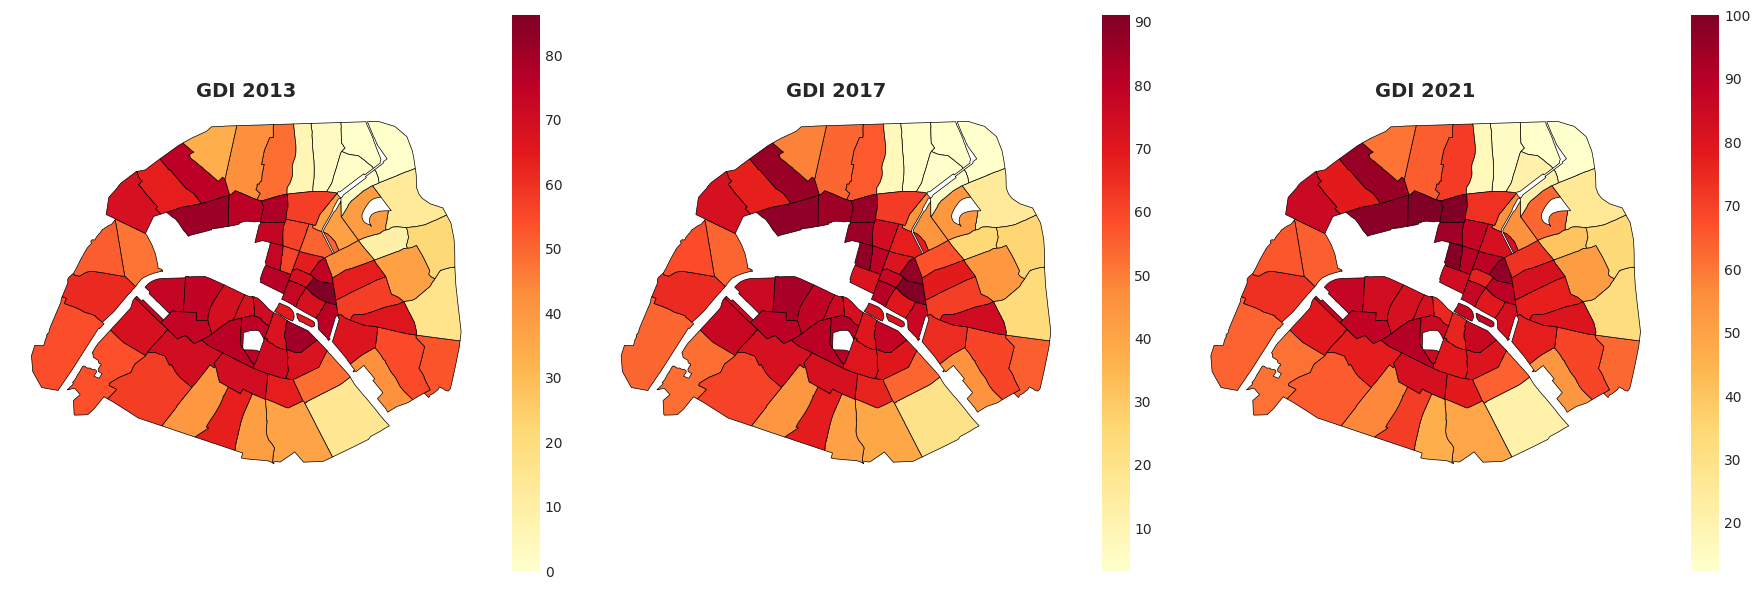

In [37]:
# Map: GDI levels across three years
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, year in enumerate([2013, 2017, 2021]):
    var = f'GDI_{year}'
    gdf_analysis.plot(
        column=var,
        cmap='YlOrRd',
        legend=True,
        ax=axes[i],
        edgecolor='black',
        linewidth=0.5
    )
    axes[i].set_title(f'GDI {year}', fontsize=14, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'gdi_maps_by_year.png', dpi=300, bbox_inches='tight')
plt.show()

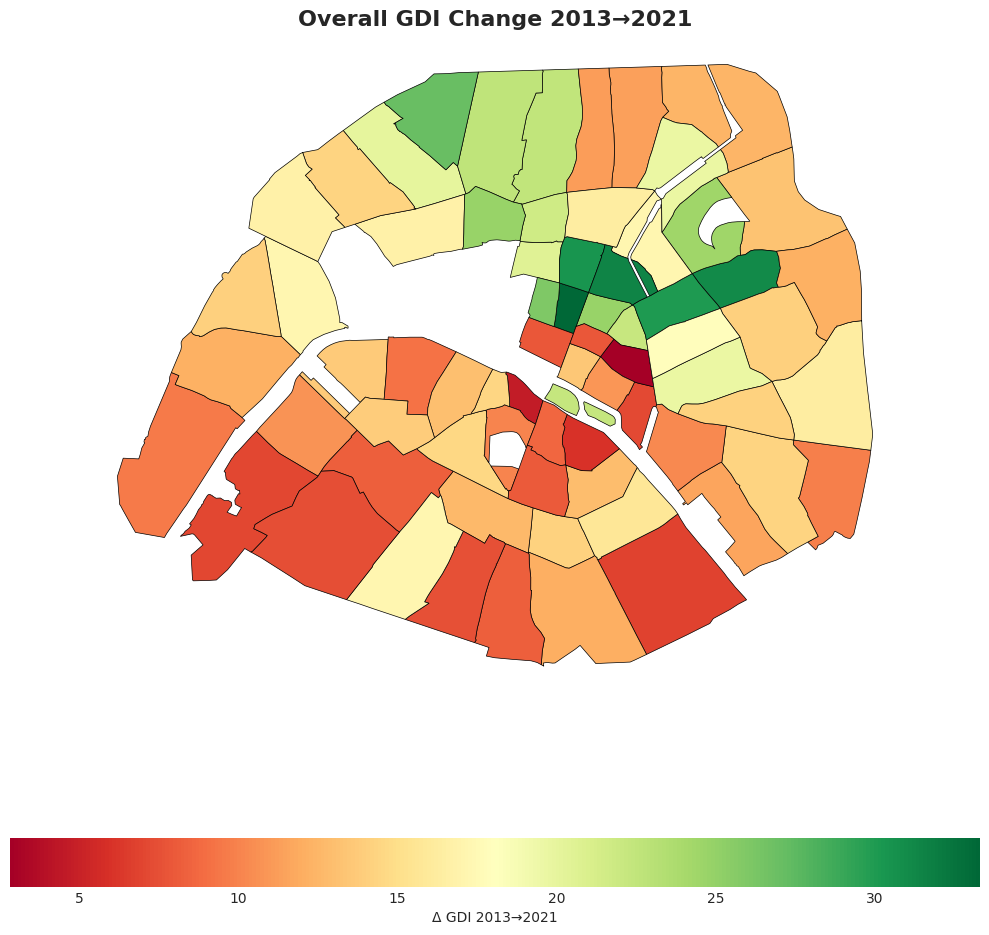

In [38]:
# Map: Overall change 2013→2021
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

gdf_analysis.plot(
    column='delta_13_21',
    cmap='RdYlGn',
    legend=True,
    ax=ax,
    edgecolor='black',
    linewidth=0.5,
    legend_kwds={'label': 'Δ GDI 2013→2021', 'orientation': 'horizontal'}
)
ax.set_title('Overall GDI Change 2013→2021', fontsize=16, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'gdi_change_map.png', dpi=300, bbox_inches='tight')
plt.show()

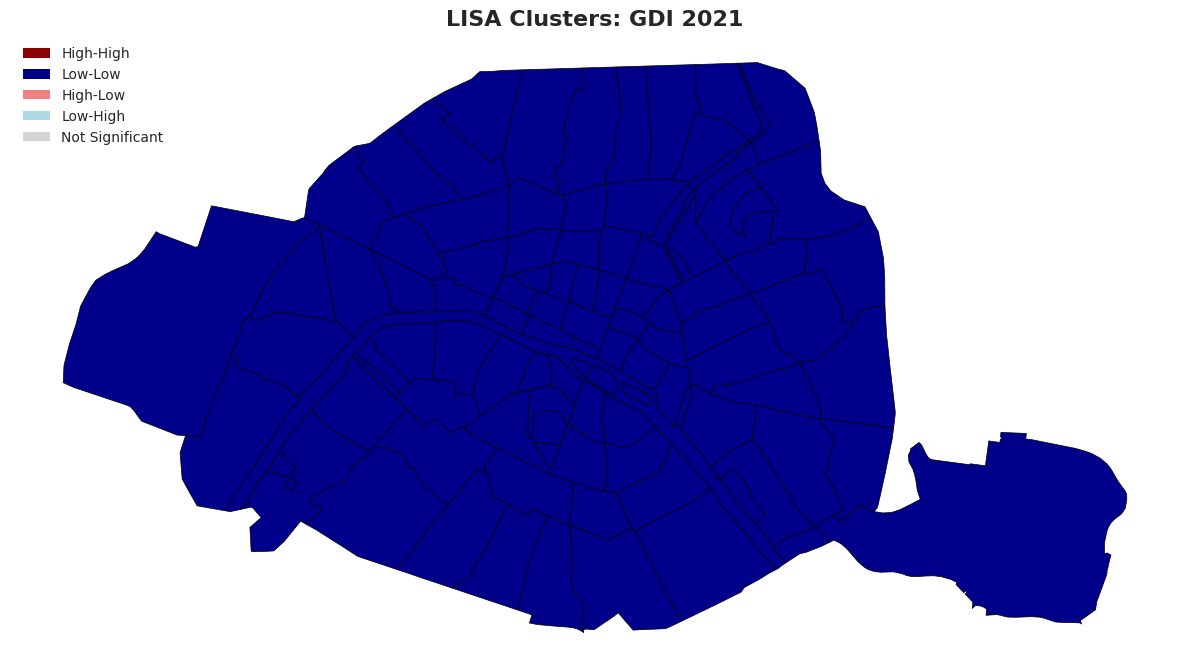

In [39]:
# Map: LISA clusters for GDI 2021
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Define colors for cluster types
cluster_colors = {
    'High-High': 'darkred',
    'Low-Low': 'darkblue',
    'High-Low': 'lightcoral',
    'Low-High': 'lightblue',
    'Not Significant': 'lightgrey'
}

gdf_analysis['lisa_color_2021'] = gdf_analysis['lisa_label_2021'].map(cluster_colors)

gdf_analysis.plot(
    color=gdf_analysis['lisa_color_2021'],
    ax=ax,
    edgecolor='black',
    linewidth=0.5
)

# Create legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=label) for label, color in cluster_colors.items()]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

ax.set_title('LISA Clusters: GDI 2021', fontsize=16, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'lisa_clusters_gdi_2021.png', dpi=300, bbox_inches='tight')
plt.show()

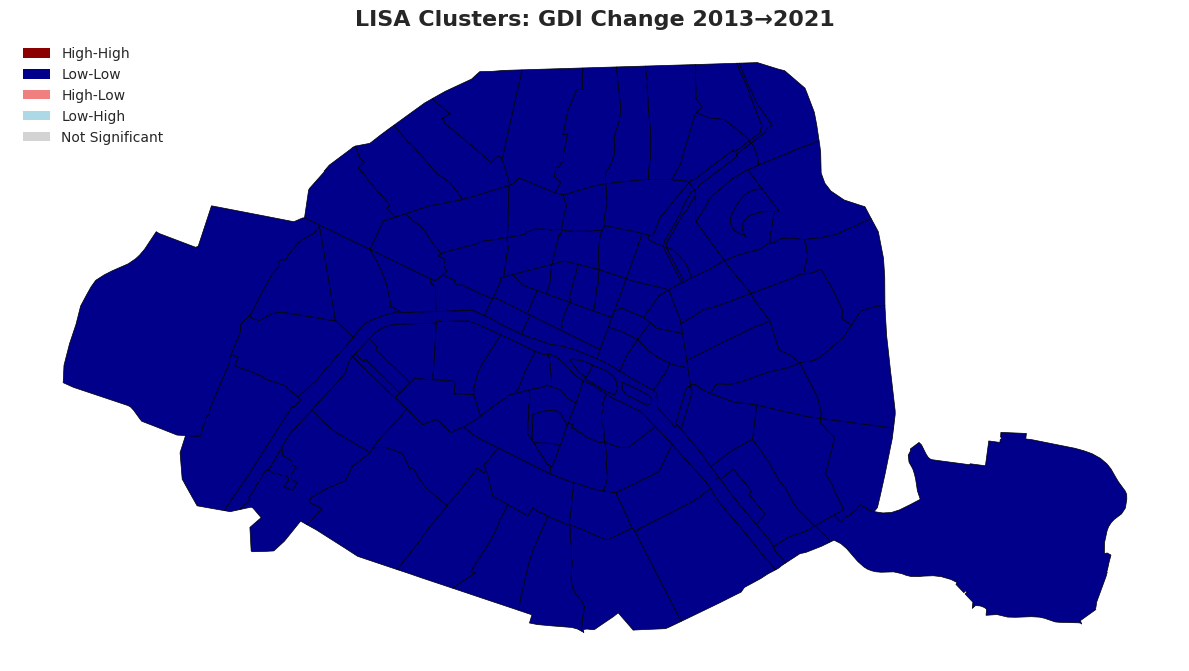

In [40]:
# Map: LISA clusters for change
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

gdf_analysis['lisa_color_change'] = gdf_analysis['lisa_label_change'].map(cluster_colors)

gdf_analysis.plot(
    color=gdf_analysis['lisa_color_change'],
    ax=ax,
    edgecolor='black',
    linewidth=0.5
)

ax.legend(handles=legend_elements, loc='upper left', fontsize=10)
ax.set_title('LISA Clusters: GDI Change 2013→2021', fontsize=16, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'lisa_clusters_gdi_change.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Sensitivity Analysis: PCA-Based Weights

We test robustness by computing alternative composite weights using Principal Components Analysis.

In [41]:
# PCA on standardized indicators
z_indicator_cols = [f'z_{var}' for var, _, _ in indicators]
X = df[z_indicator_cols].values

pca = PCA()
pca.fit(X)

print("PCA Explained Variance:")
for i, var in enumerate(pca.explained_variance_ratio_[:5]):
    print(f"  PC{i+1}: {var:.3f} ({pca.explained_variance_ratio_[:i+1].sum():.3f} cumulative)")

# Loadings of first component
loadings_pc1 = pca.components_[0]
loading_df = pd.DataFrame({
    'Indicator': [var for var, _, _ in indicators],
    'PC1_Loading': loadings_pc1
})
loading_df['Abs_Loading'] = loading_df['PC1_Loading'].abs()
loading_df = loading_df.sort_values('Abs_Loading', ascending=False)

print("\nPC1 Loadings (sorted by absolute value):")
print(loading_df.to_string(index=False))

PCA Explained Variance:
  PC1: 0.625 (0.625 cumulative)
  PC2: 0.215 (0.840 cumulative)
  PC3: 0.085 (0.925 cumulative)
  PC4: 0.037 (0.962 cumulative)
  PC5: 0.023 (0.985 cumulative)

PC1 Loadings (sorted by absolute value):
     Indicator  PC1_Loading  Abs_Loading
  pct_ouvriers        0.446        0.446
   pct_bac_sup        0.443        0.443
     median_uc        0.423        0.423
prix_m2_median        0.385        0.385
  pct_immigres        0.348        0.348
    pct_cadres        0.341        0.341
   age_balance       -0.198        0.198


In [42]:
# Compute PCA-weighted composite using PC1 scores
pc1_scores = pca.transform(X)[:, 0]

# Align PC1 direction with gentrification (higher = more gentrified)
# Check correlation with median_uc
if np.corrcoef(pc1_scores, df['median_uc'])[0, 1] < 0:
    pc1_scores = -pc1_scores
    print("PC1 direction flipped to align with gentrification signal.")

df['GDI_PCA_raw'] = pc1_scores

# Rescale to 0-100
pca_min = df['GDI_PCA_raw'].min()
pca_max = df['GDI_PCA_raw'].max()
df['GDI_PCA'] = 100 * (df['GDI_PCA_raw'] - pca_min) / (pca_max - pca_min)

print(f"\nPCA-weighted GDI created.")
print(f"Range: {df['GDI_PCA'].min():.1f} to {df['GDI_PCA'].max():.1f}")


PCA-weighted GDI created.
Range: 0.0 to 100.0



Correlation between equal-weight and PCA-weighted GDI:
  Pearson: 0.9507
  Spearman: 0.9025
  Kendall: 0.7423


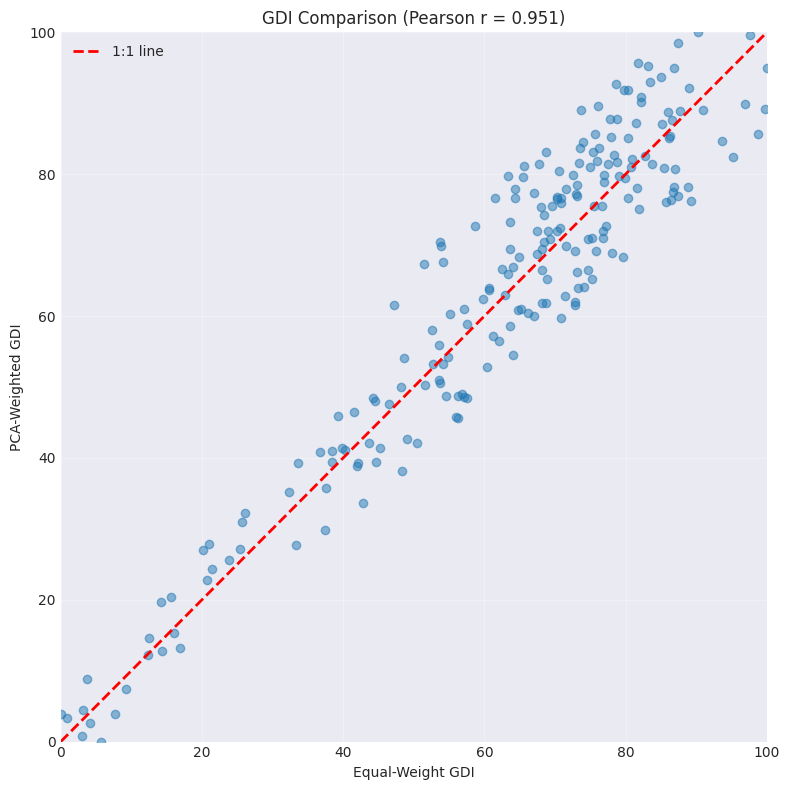

In [44]:
# Compare equal-weight and PCA-weighted GDI
comparison = df[['neighborhood', 'annee', 'GDI', 'GDI_PCA']].copy()

# Correlations
corr_pearson = comparison[['GDI', 'GDI_PCA']].corr().iloc[0, 1]
corr_spearman, _ = spearmanr(comparison['GDI'], comparison['GDI_PCA'])
corr_kendall, _ = kendalltau(comparison['GDI'], comparison['GDI_PCA'])

print(f"\nCorrelation between equal-weight and PCA-weighted GDI:")
print(f"  Pearson: {corr_pearson:.4f}")
print(f"  Spearman: {corr_spearman:.4f}")
print(f"  Kendall: {corr_kendall:.4f}")

# Scatter plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(comparison['GDI'], comparison['GDI_PCA'], alpha=0.5)
ax.plot([0, 100], [0, 100], 'r--', linewidth=2, label='1:1 line')
ax.set_xlabel('Equal-Weight GDI')
ax.set_ylabel('PCA-Weighted GDI')
ax.set_title(f'GDI Comparison (Pearson r = {corr_pearson:.3f})')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'gdi_sensitivity_pca.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. Internal Consistency: Cronbach's Alpha

We compute Cronbach's alpha to assess internal consistency within each dimension and overall.

In [45]:
def cronbach_alpha(df, columns):
    """
    Compute Cronbach's alpha for a set of items.
    """
    df_items = df[columns].dropna()
    n_items = len(columns)
    
    # Item variances
    item_vars = df_items.var(axis=0, ddof=1)
    
    # Total score variance
    total_var = df_items.sum(axis=1).var(ddof=1)
    
    # Cronbach's alpha
    alpha = (n_items / (n_items - 1)) * (1 - item_vars.sum() / total_var)
    
    return alpha

# Overall alpha
alpha_overall = cronbach_alpha(df, z_indicator_cols)
print(f"Cronbach's alpha (all indicators): {alpha_overall:.3f}")

# Dimension-specific alpha
econ_cols = [f'z_{var}' for var, _, dim in indicators if dim == 'Economic']
social_cols = [f'z_{var}' for var, _, dim in indicators if dim == 'Social']
demo_cols = [f'z_{var}' for var, _, dim in indicators if dim == 'Demographic']

alpha_econ = cronbach_alpha(df, econ_cols)
alpha_social = cronbach_alpha(df, social_cols)
alpha_demo = cronbach_alpha(df, demo_cols)

print(f"\nDimension-specific Cronbach's alpha:")
print(f"  Economic: {alpha_econ:.3f}")
print(f"  Social: {alpha_social:.3f}")
print(f"  Demographic: {alpha_demo:.3f}")

print("\nInterpretation guideline:")
print("  α ≥ 0.9: Excellent")
print("  0.8 ≤ α < 0.9: Good")
print("  0.7 ≤ α < 0.8: Acceptable")
print("  0.6 ≤ α < 0.7: Questionable")
print("  α < 0.6: Poor")

Cronbach's alpha (all indicators): 0.814

Dimension-specific Cronbach's alpha:
  Economic: 0.843
  Social: 0.905
  Demographic: -0.485

Interpretation guideline:
  α ≥ 0.9: Excellent
  0.8 ≤ α < 0.9: Good
  0.7 ≤ α < 0.8: Acceptable
  0.6 ≤ α < 0.7: Questionable
  α < 0.6: Poor


## 12. Cluster Analysis: Neighborhood Typologies

We use k-means clustering on the three subindices to identify neighborhood typologies.

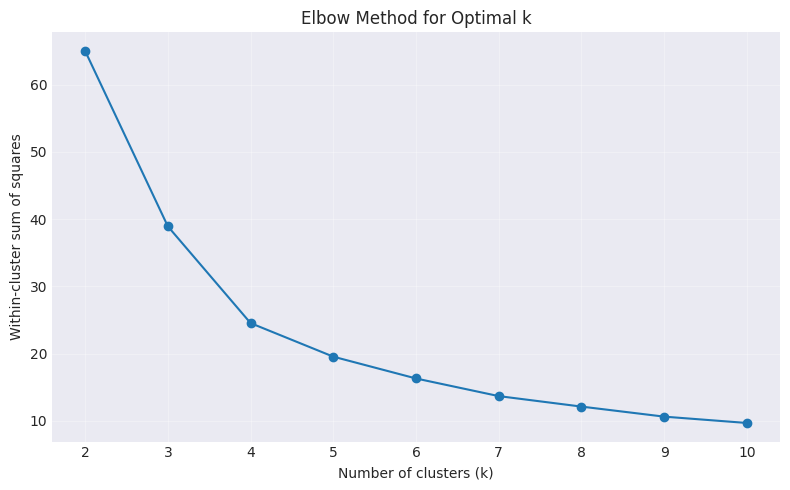

In [46]:
# Prepare data for clustering (using 2021 cross-section)
df_2021 = df[df['annee'] == 2021].copy()
cluster_features = ['E', 'S', 'D']
X_cluster = df_2021[cluster_features].values

# Elbow method to choose k
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster)
    inertias.append(kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(K_range, inertias, marker='o')
ax.set_xlabel('Number of clusters (k)')
ax.set_ylabel('Within-cluster sum of squares')
ax.set_title('Elbow Method for Optimal k')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'cluster_elbow.png', dpi=300, bbox_inches='tight')
plt.show()

In [47]:
# Fit k-means with chosen k (e.g., k=4)
k_chosen = 4
kmeans = KMeans(n_clusters=k_chosen, random_state=42, n_init=10)
df_2021['cluster'] = kmeans.fit_predict(X_cluster)

print(f"\nK-means clustering with k={k_chosen}")
print(f"Cluster sizes:")
print(df_2021['cluster'].value_counts().sort_index())

# Cluster profiles
profile_cols = ['E', 'S', 'D', 'GDI'] + ['median_uc', 'prix_m2_median', 'pct_cadres', 'pct_bac_sup']
cluster_profiles = df_2021.groupby('cluster')[profile_cols].mean()

print("\nCluster profiles (mean values):")
print(cluster_profiles.round(2))


K-means clustering with k=4
Cluster sizes:
cluster
0    28
1     9
2    18
3    16
Name: count, dtype: int64

Cluster profiles (mean values):
            E     S     D    GDI  median_uc  prix_m2_median  pct_cadres  \
cluster                                                                   
0        0.72  0.89  0.45  86.06   35367.68        11859.83       36.44   
1       -0.86 -1.67 -0.76  24.13   22571.11         9092.85       21.86   
2       -0.05 -0.07  0.07  61.60   29879.72        10298.78       31.25   
3        1.58  0.48 -0.65  78.62   42630.00        13611.37       29.98   

         pct_bac_sup  
cluster               
0              61.73  
1              42.14  
2              53.22  
3              59.28  


In [48]:
# Assign interpretive labels to clusters based on profiles
# This is a manual step informed by the profiles
# Example labels (adjust based on actual profiles):
cluster_labels_map = {
    0: 'Cluster 0',
    1: 'Cluster 1',
    2: 'Cluster 2',
    3: 'Cluster 3'
}

df_2021['cluster_label'] = df_2021['cluster'].map(cluster_labels_map)

print("\nCluster labels:")
print(df_2021['cluster_label'].value_counts())


Cluster labels:
cluster_label
Cluster 0    28
Cluster 2    18
Cluster 3    16
Cluster 1     9
Name: count, dtype: int64


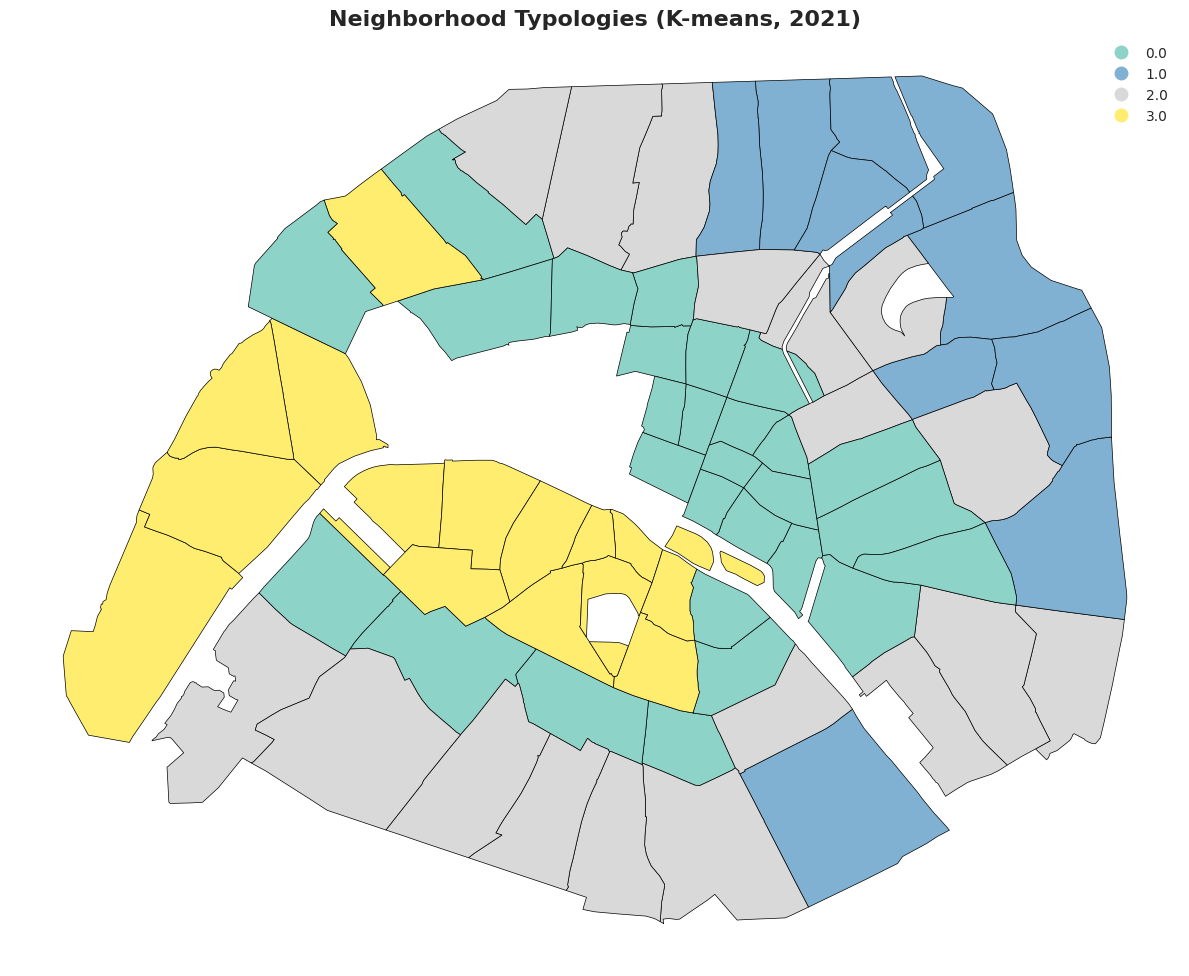

In [54]:
# Map clusters
gdf_2021 = gdf.merge(df_2021[['neighborhood', 'cluster', 'cluster_label']], 
                     left_on='quartier', right_on='neighborhood', how='left')

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

gdf_2021.plot(
    column='cluster',
    categorical=True,
    cmap='Set3',
    legend=True,
    ax=ax,
    edgecolor='black',
    linewidth=0.5
)

ax.set_title('Neighborhood Typologies (K-means, 2021)', fontsize=16, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'neighborhood_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

## 13. Export Results

We export the key analytical outputs for further use and documentation.

In [55]:
# Export long-format panel with GDI and subindices
export_cols = ['neighborhood', 'annee', 'median_uc', 'prix_m2_median', 
               'pct_cadres', 'pct_ouvriers', 'pct_bac_sup', 'age_balance', 'pct_immigres',
               'E', 'S', 'D', 'GDI', 'GDI_PCA']
df[export_cols].to_parquet(OUTPUT_DIR / 'paris_gdi_panel.parquet', index=False)
print("Exported panel to paris_gdi_panel.parquet")

# Export wide-format change data
wide.to_csv(OUTPUT_DIR / 'paris_gdi_change.csv', index=False)
print("Exported change metrics to paris_gdi_change.csv")

# Export GeoDataFrame with spatial analysis results
gdf_analysis.to_file(OUTPUT_DIR / 'paris_gdi_spatial.geojson', driver='GeoJSON')
print("Exported spatial analysis to paris_gdi_spatial.geojson")

Exported panel to paris_gdi_panel.parquet
Exported change metrics to paris_gdi_change.csv
Exported spatial analysis to paris_gdi_spatial.geojson


## 14. Summary and Key Findings

This notebook has implemented a comprehensive Gentrification Degree Index (GDI) for 71 Parisian residential neighborhoods across 2013, 2017, and 2021. Key methodological features include:

1. **Transparent indicator selection**: Seven theory-grounded indicators spanning economic, social, and demographic dimensions
2. **Pooled standardization**: Temporal comparability through z-scores computed across all years
3. **Dimension-balanced aggregation**: Equal weighting within and across dimensions to prevent structural imbalance
4. **Longitudinal change framework**: Velocity, acceleration, and baseline-adjusted metrics
5. **Spatial diagnostics**: Global and local Moran's I to identify clustering patterns
6. **Sensitivity analysis**: PCA-based alternative weights and internal consistency checks
7. **Neighborhood typologies**: K-means clustering reveals distinct trajectory groups

### Next Steps

- Interpret cluster profiles and assign substantive labels
- Examine outlier neighborhoods for qualitative context
- Cross-validate with auxiliary data (e.g., building permits, amenity changes)
- Integrate findings into thesis narrative with maps and tables

In [56]:
# Final summary statistics table
summary = pd.DataFrame({
    'Metric': ['Mean GDI 2013', 'Mean GDI 2021', 'Mean Δ 2013→2021', 
               'SD Δ 2013→2021', 'Accelerating (n)', 'Declining (n)',
               'Global Moran I (2021)', 'PCA-GDI correlation'],
    'Value': [
        f"{df[df['annee']==2013]['GDI'].mean():.1f}",
        f"{df[df['annee']==2021]['GDI'].mean():.1f}",
        f"{wide['delta_13_21'].mean():.2f}",
        f"{wide['delta_13_21'].std():.2f}",
        f"{(wide['trajectory']=='Accelerating').sum()}",
        f"{(wide['trajectory']=='Declining/Non-gentrifying').sum()}",
        f"{morans[2021].I:.3f} (p={morans[2021].p_sim:.3f})",
        f"{corr_spearman:.3f}"
    ]
})

print("\n" + "="*60)
print("GDI IMPLEMENTATION SUMMARY")
print("="*60)
print(summary.to_string(index=False))
print("="*60)


GDI IMPLEMENTATION SUMMARY
               Metric         Value
        Mean GDI 2013          55.1
        Mean GDI 2021          70.3
     Mean Δ 2013→2021         15.27
       SD Δ 2013→2021          7.03
     Accelerating (n)             4
        Declining (n)            18
Global Moran I (2021) nan (p=0.001)
  PCA-GDI correlation         0.903
